# Gaussian Processes

A demonstration of how to sample from, and fit to, a Gaussian Process.

If a function $f(x)$ is drawn from a Gaussian process

$$f(x) \sim \mathcal{GP}(m(x)=0,k(x,x'))$$

then a finite subset of function values $\mathbf{f}=(f(x_1),f(x_1),\dots,f(x_n))^T$ are distributed such that

$$\mathbf{f}\sim \mathcal{N}(0,\Sigma)$$

where $\Sigma_{ij}=k(x_i,x_j)$

Based on lectures from Machine Learning Summer School, Cambridge 2009, see http://videolectures.net/mlss09uk_rasmussen_gp/

Author: Juvid Aryaman

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import utls 

In [57]:
utls.reset_plots()
%matplotlib inline

## Sample from a Gaussian Process

In [76]:
def cov_matrix_function(x1,x2,l):
    """Use a squared exponential covariance with a fixed length scale
    :param x1: A double, parameter of the covariance function
    :param x2: A double, parameter of the covariance function
    :param l: A double, hyperparameter of the GP determining the length scale over which the correlation between neighbouring points decays
    Returns: Squared exponential covariance function
    """
    return np.exp(-(x1-x2)*(x1-x2)/l)

In [77]:
D = 90 # number of points along x where we will evaluate the GP. D = dimension of the cov matrix
x = np.linspace(-5,5,D)
ndraws = 5 # number of functions to draw from GP

In [78]:
cmap = plt.cm.jet

In [96]:
def sample_from_gp(l):
    """
    Sample from a Gaussian Process
    :param l: The length scale of the squared exponential GP
    Returns: A numpy array of length (D) as a draw from the GP
    """
    sigma = np.zeros((D,D))
    for i in range(D):
        for j in range(D):
            sigma[i,j] = cov_matrix_function(x[i],x[j],l)
    return sigma, np.random.multivariate_normal(np.zeros(D),sigma) # sample from the GP

In [97]:
def add_GP_draws_to_plot(ax, l):
    """Add a number of samples from a Gaussian process to a plot
    :param ax: A AxesSubplot object, the axes to plot on
    :param l: The length scale of the squared exponential GP
    """
    for k in range(ndraws):
        sigma, y = sample_from_gp(l)
        col = cmap(int(round((k+1)/float(ndraws)*(cmap.N))))
        ax.plot(x,y,'-',alpha=0.5,color=col, linewidth = 2)
    ax.set_xlabel('Input, $x$')
    ax.set_ylabel('Output, $f(x)$')
    ax.set_title('$l={}$'.format(l),fontsize=20)

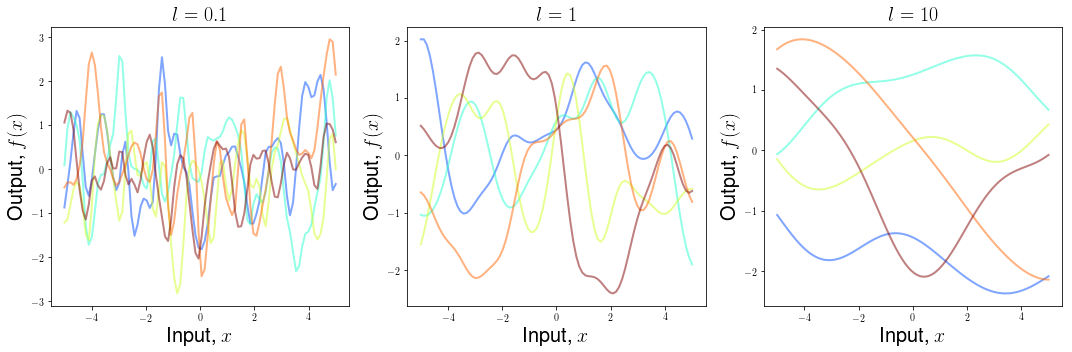

In [98]:
fig, axs = plt.subplots(1,3,figsize=(3*5,5))
axs = axs.ravel()
add_GP_draws_to_plot(axs[0],0.1)
add_GP_draws_to_plot(axs[1],1)
add_GP_draws_to_plot(axs[2],10)
plt.tight_layout()

Each panel shows 5 draws from a different Gaussian process. All of the panels use a covariance function of the same form, namely a squared exponential covariance function:

$$k(x,x')=\exp\left(-\frac{1}{l}(x-x')^2\right)$$

The function has a *hyperparameter* $l$ which determines the length scale over which the correlation between neighbouring points decays. Here we show what happens as $l$ is increased: the curvature of each function reduces. A large $l$ means that $k(x,x')$ reduces slowly with $x$ for some fixed $x'$, so neighbouring points have a high correlation, and therefore the sampled function $f(x)$ changes slowly with $x$.

Each colored line is a single sample from a Gaussian process. Each panel has a fixed $\Sigma_{i,j}$. However, every time we draw from the multivariate Gaussian $\mathcal{N}(0,\Sigma)$, we get a different vector $\mathbf{f}$, and therefore a different shaped curve.

Notice that we only evaluate the Gaussian process at `D` different points. If we wanted to evaluate the Gaussian process everywhere in $x$, we would need `D` to become infinity (which is impossible!). It is in this sense that we can consider a Gaussian process as a generalisation of a multivariate Gaussian distribution to infinitely many variables, because $\Sigma$ would need to be an $(\infty,\infty)$ matrix for us to evaluate $f(x)$ everywhere.

## Bayesian Inference with Gaussian Processes

One of the great things about Gaussian processes is that we can do Bayesian inference with them analytically (i.e. we can write down the posterior distribution, and the posterior predictive distribution, in terms of the data mathematically without needing to resort to expensive Monte Carlo algorithms)

The problem setting is that we have some data $\mathcal{D}=(\mathbf{x},\mathbf{y})$ and we want to make a prediction of the value of $y^*$ at some value of $x^*$ where we have no data. We do not know the functional form of $\mathbf{y}$, so we will use a Gaussian process.

We model the data as having a Gaussian likelihood

$$\mathbf{y}|\mathbf{x},f(x),M \sim \mathcal{N}(\mathbf{f},\sigma_{\text{noise}}^2)$$

where $M$ is our choice of model (namely a Gaussian process, with its associated hyperparameters) and $\sigma_{\text{noise}}$ is the noise in our data.

We then use a Gaussian process prior

$$f(x)|M\sim \mathcal{GP}(m(x)\equiv0,k(x,x'))$$

It turns out that this is a conjugate prior, where the posterior is also a Gaussian process. Note that, in this language, $f(x)$ takes the position of the parameters ($\theta$) in Bayes rule

$$p(\theta|\mathcal{D},M)=\frac{p(\mathcal{D}|\theta,M) p(\theta|M)}{p(\mathcal{D}|M)}$$

where $p(\theta|\mathcal{D},M)$ is the posterior, $p(\mathcal{D}|\theta,M)$ is the likelihood, $p(\theta|M)$ is the prior and $p(\mathcal{D}|M)$ is the marginal likelihood. So, in this sense, a Gaussian process is a parametric model with an infinite number of parameters (since a function has an infinite number of values in any given range of $x$).


### Make some pseudo-data

We will generate some data as a draw from a GP. For this demo, we will assume that 

1. The data really were generated from a Gaussian process, and we know what the appropriate covariance function $k(x,x')$ is to use. In practice, this is unavoidable and is a modelling choice.
2. We know the values of the hyperparameters of the Gaussian process which generated our data. This is somewhat contrived for the sake of demonstration. Whilst we may sometimes know parameters like the noise in our data (`sigma_noise` below), we will probably not know parameters such as $l$ in the above example. In practice, we can maximize the marginal likelihood to learn 'best fit' values of the hyperparameters of our Gaussian process.

In [114]:
l = 1 
sigma_noise = 0.005

In [115]:
sigma_true, y_true = sample_from_gp(l) # The true function, a sample from a GP 

data_n = 10
data_indicies = np.random.choice(D,data_n,replace=False)

data_y = y_true[data_indicies]
data_x = x[data_indicies]

So we have our data, `data_y` and `data_x`. We now want to make predictions about there values over all values in the variable `x`.

### Compute the posterior predictive distribution of the Gaussian process

In [116]:
K = np.zeros((data_n,data_n)) # make a covariance matrix
for i in range(data_n):
	for j in range(data_n):
		K[i,j] = cov_matrix_function(data_x[i],data_x[j],l) # squared exponential GP

means = np.zeros(D)
variances = np.zeros(D)
for i, xs in enumerate(x):
	k = cov_matrix_function(xs, data_x, l) 
	K_inv_n = np.linalg.inv( K + sigma_noise*np.identity(data_n) ) 
	v = np.dot(K_inv_n, data_y)
	mean = np.dot(k, v)

	v2 = np.dot(K_inv_n, k)
	var = cov_matrix_function(xs, xs, l) + sigma_noise - np.dot(k, v2)

	means[i] = mean
	variances[i] = var

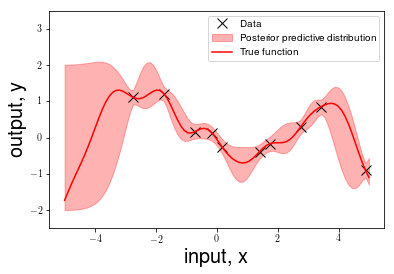

In [117]:
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc="red", alpha = 0.3, ec = 'red')
p3 = mlines.Line2D([], [], color='red')

# Plot a 95% BCI using the 2 sigma rule for Normal distributions
fig, ax = plt.subplots()
ax.fill_between(x, means+2*np.sqrt(variances), means-2*np.sqrt(variances), color='red', alpha=0.3)
p1=ax.plot(data_x, data_y, 'kx')



ax.plot(x, y_true,'-r')
ax.set_xlabel('input, x')
ax.set_ylabel('output, y')
ax.set_ylim([-2.5,3.5])
ax.legend([p1[0],p2, p3], ['Data', 'Posterior predictive distribution', 'True function']);

We have plotted the true function the data came from. The shaded region is a 95% Bayesian confidence interval of the value of $y$ at any particular $x$. That means we have used all of the data we have to constrain the possible values of $x$ where we do not already have data. 

Even where we have data, the $y$ is non-zero due to the existen measurement error (i.e. $\sigma_{\text{noise}}>0$.